Teste técnico - Risk Analyst Cloudwalk.

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



<h1 style='color:#ED7261'>RAW DATA ANALYSIS</h1>

After importing the libs we are gona use. 
It is important to import and sanitize the data to be trained in our model

In [38]:
dataset = pd.read_csv('transactions.csv')

def clean_card_number(card):
    return int(''.join(filter(str.isdigit, card)))
dataset['card_number'] = dataset['card_number'].apply(clean_card_number)

# Convert 'transaction_date' to datetime
dataset['transaction_date'] = pd.to_datetime(dataset['transaction_date'])

# Extract hour and minute components separately
# And Combine hour and minute components into a single integer
dataset['transaction_hour'] = dataset['transaction_date'].dt.hour.astype(int)
dataset['transaction_minute'] = dataset['transaction_date'].dt.minute.astype(int)
dataset['transaction_hour_minute'] = dataset['transaction_hour'] * 100 + dataset['transaction_minute']

# Drop the separate hour and minute columns for irrelevancy
dataset.drop(columns=['transaction_hour', 'transaction_minute'], inplace=True)



dataset['transaction_date'] = dataset['transaction_date'].astype(int)

print(dataset.head(1))



   transaction_id  merchant_id  user_id  card_number     transaction_date  \
0        21320398        29744    97051   4345059116  1575242192812632000   

   transaction_amount  device_id  has_cbk  transaction_hour_minute  
0              374.56   285475.0    False                     2316  


Lets first try to pull out useful data from the dataset before trying to create and apply any models or solutions to the detection mechanism

In [39]:
print('Transações legítimas (FALSE) vs Fraudes (TRUE):')
print(dataset['has_cbk'].value_counts())

print()
print('Integridade de dados:')
missing_values = dataset.isnull().sum()
print(missing_values)

# Changes the missing device ids to 0
dataset['device_id'] = dataset['device_id'].fillna(0)


Transações legítimas (FALSE) vs Fraudes (TRUE):
False    2808
True      391
Name: has_cbk, dtype: int64

Integridade de dados:
transaction_id               0
merchant_id                  0
user_id                      0
card_number                  0
transaction_date             0
transaction_amount           0
device_id                  830
has_cbk                      0
transaction_hour_minute      0
dtype: int64


There are 3199 transactions in total, of which, 391 (12%) frauds and 2808 (88%) legitimate transactions.

And we also see that we have 830 transactions where the device id is missing, which cannot be discarded, because they present real use data, so a workaround this issue has to be developed.

Searching manually in the dataset, I found that 67 out of the 830 (8%)transactions lacking device ids were fraudulent, so the lack of device id has no relevant effect on the fraud amount on first sight. 

In [40]:
grouped_transactions = dataset.groupby('card_number').size()
print('registered transactions:')
print(grouped_transactions)
print()

# Find where a fraud occured and count occurrences
fraud_occurrences = dataset[dataset['has_cbk'] == True]
count = fraud_occurrences.shape[0]

# Print the ammount of occurences of fraud
print("Occurrences of 'fraud':")
# print(occurrences)
print("Count of occurrences:", count)

# print the ammount of frauds of each card
grouped_frauds = fraud_occurrences.groupby('card_number').size()
print(grouped_frauds)



registered transactions:
card_number
45938330       1
50677590       1
230744950      1
404024820      1
406655470      1
              ..
6550066876     1
6550077278     1
23074410000    1
44152410003    1
45321110004    1
Length: 2925, dtype: int64

Occurrences of 'fraud':
Count of occurrences: 391
card_number
230744950     1
515590820     1
606282450     1
2306505729    1
2307444802    2
             ..
6504864290    1
6505167004    1
6505169201    3
6507275418    3
6516532256    5
Length: 274, dtype: int64


In [41]:
# Calculate the total registered transactions for each card
total_transactions_by_card = grouped_transactions

# Calculate the count of fraud occurrences for each card
fraud_occurrences_by_card = fraud_occurrences.groupby('card_number').size()

# Compare fraud occurrences to registered transactions for each card
fraud_ratio_by_card = fraud_occurrences_by_card / total_transactions_by_card

fraud_ratio_by_card = fraud_ratio_by_card.fillna(0)

# Print the fraud ratio for each card
print("Fraud ratio for each card:")
print(fraud_ratio_by_card)


Fraud ratio for each card:
card_number
45938330       0.0
50677590       0.0
230744950      1.0
404024820      0.0
406655470      0.0
              ... 
6550066876     0.0
6550077278     0.0
23074410000    0.0
44152410003    0.0
45321110004    0.0
Length: 2925, dtype: float64


In the last two cells, we can see that there are 2925 cards on the database and 274 of those have registered fraudulent transactions. So there is no significant individual card history to be analyzed to track spending habits and do an individual card fraud analysis.

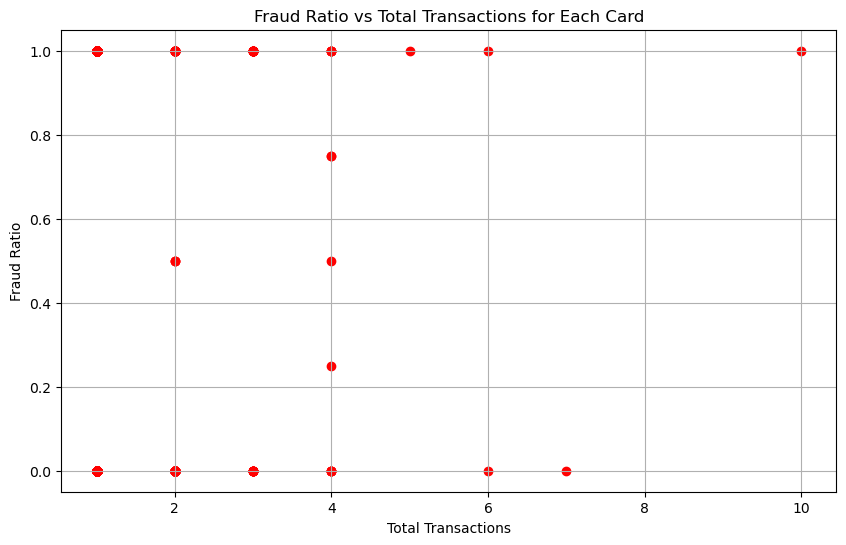

In [50]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(total_transactions_by_card, fraud_ratio_by_card, color='r')
plt.xlabel('Total Transactions')
plt.ylabel('Fraud Ratio')
plt.title('Fraud Ratio vs Total Transactions for Each Card')



plt.grid(True)
plt.show()



This graph shows us that the number of registered transactions is not particularly telling of fraud.  So it is necessary to find other methods that might help us find a pattern.

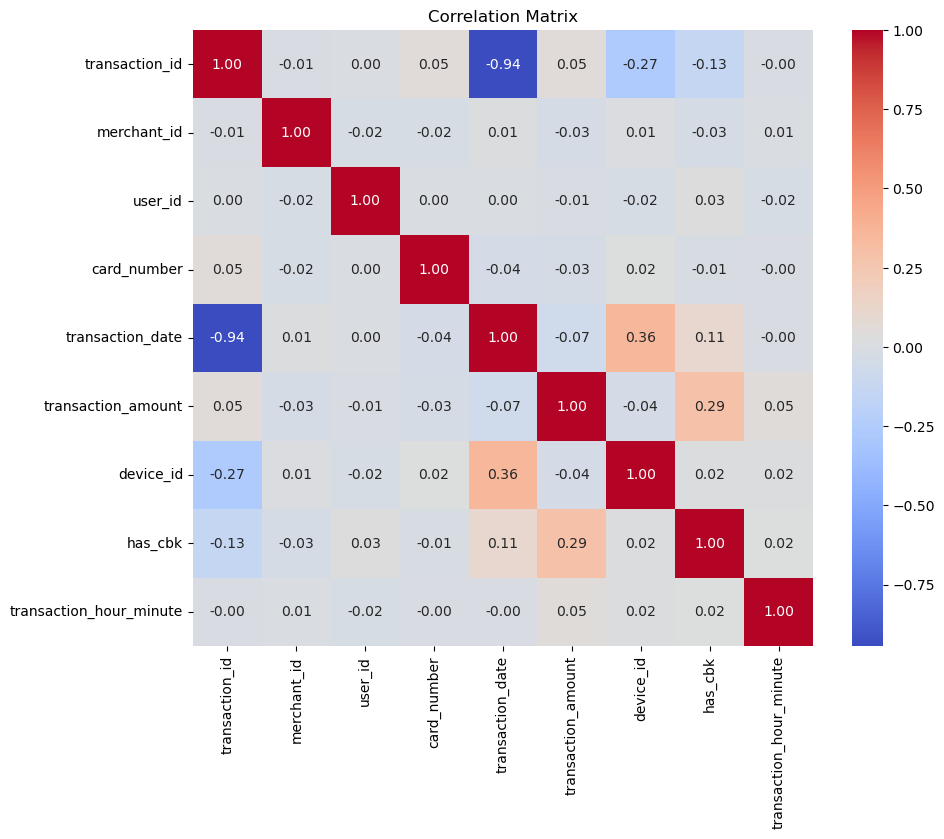

In [43]:
corr_matrix = dataset.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()



From the correlation, it is possible to see that most of the characteristics have little correlation to has_cbk (the variable that tells if the transaction was fraudulent)

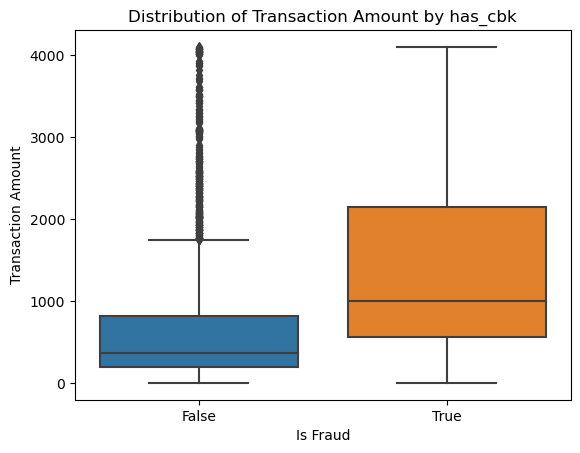

In [44]:

sns.boxplot(x='has_cbk', y='transaction_amount', data=dataset)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.title('Distribution of Transaction Amount by has_cbk')
plt.show()


This boxplot suggests that the transaction amount is typically higher on fraudulent interactions, but there are many outliers that also indicate that big amount transactions can also be legitimate. So one viable solution to reduce the amount of fraud would be a second factor autentication option for large transactions.

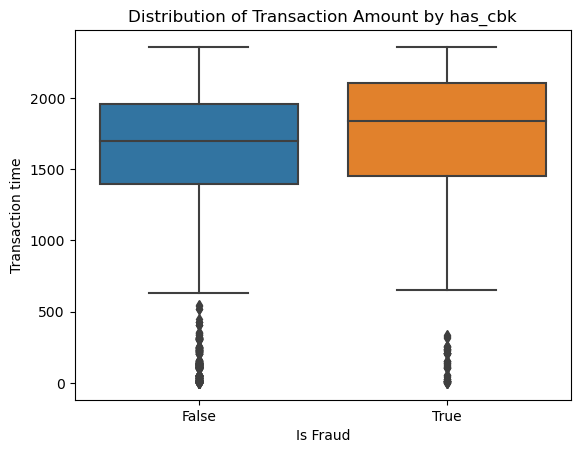

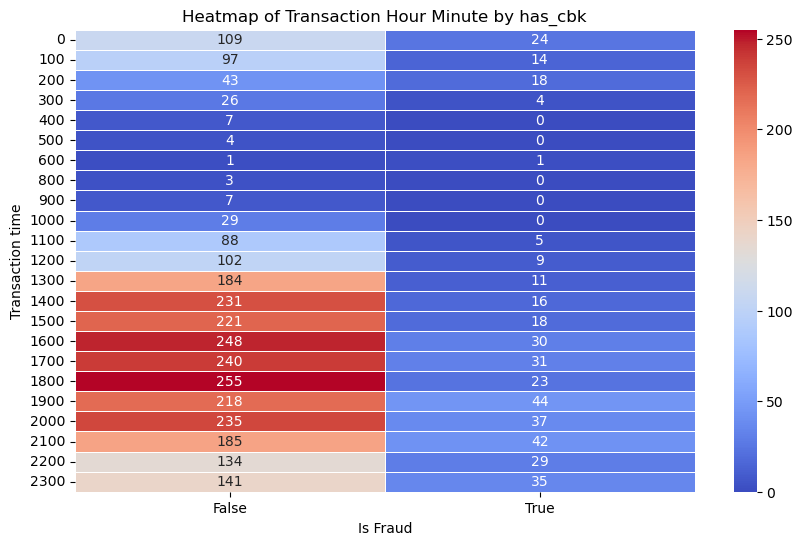

In [45]:

sns.boxplot(x='has_cbk', y='transaction_hour_minute', data=dataset)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction time')
plt.title('Distribution of Transaction Amount by has_cbk')
plt.show()

dataset['transaction_hour_minute_rounded'] = dataset['transaction_hour_minute'] // 100 * 100

# Create the heatmap
plt.figure(figsize=(10, 6))
heatmap_data = dataset.pivot_table(index='transaction_hour_minute_rounded', columns='has_cbk', aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d', linewidths=.5)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction time')
plt.title('Heatmap of Transaction Hour Minute by has_cbk')
plt.show()

In [46]:
# Round transaction_hour_minute to the nearest 100
dataset['transaction_hour_minute_rounded'] = dataset['transaction_hour_minute'] // 100 * 100

# Calculate the ratio of False to True for each interval
ratio_data = dataset.groupby(['transaction_hour_minute_rounded', 'has_cbk']).size().unstack(fill_value=0)
ratio_data['ratio'] =   ratio_data[True]/ (ratio_data[False] +  ratio_data[True])

# print(ratio_data['ratio'])
sorted_ratio_data = ratio_data.sort_values(by='ratio', ascending=False)
print(sorted_ratio_data['ratio'])


transaction_hour_minute_rounded
600     0.500000
200     0.295082
2300    0.198864
2100    0.185022
0       0.180451
2200    0.177914
1900    0.167939
2000    0.136029
300     0.133333
100     0.126126
1700    0.114391
1600    0.107914
1800    0.082734
1200    0.081081
1500    0.075314
1400    0.064777
1300    0.056410
1100    0.053763
400     0.000000
1000    0.000000
900     0.000000
800     0.000000
500     0.000000
Name: ratio, dtype: float64


In [47]:
# Identify consecutive intervals with ratios above the threshold
threshold = 0.10
higher_ratio_clusters = []
current_cluster = []

for index, row in sorted_ratio_data.iterrows():
    if row['ratio'] > threshold:
        current_cluster.append(index)
    else:
        if current_cluster:
            higher_ratio_clusters.append(current_cluster)
            current_cluster = []

# Print the identified higher ratio clusters
print("Higher Ratio :")
for cluster in higher_ratio_clusters:
    print(cluster)


Higher Ratio :
[600, 200, 2300, 2100, 0, 2200, 1900, 2000, 300, 100, 1700, 1600]


In the last 3 cells, we extract more data on what time fraud is more common and the when there is a higher ratio of fraud. The graphs show us that the most transactions occur between 11am and 1am (on the next day), and the fraudulent amount is larger than 10% between 4pm and 1am, but it is important to notice that 6am has 50% of fraud ratio. 

This is Very useful, since we can use this information to better estimate the likelyhood of fraud when joined with transaction ammounts. 

<h1 style='color:#ED7261'>DETECTION MODELS</h1>

This problem can be approached from a multitude of ways. It is possible to establish arbitrary criteria to enforce some kind of user verification by a second factor to authorize the transaction, an automatic statistical machine to autodetect fraud. 

But to do this, it is important to first state the fact that it is impossible to have a 100% accurate method, the goal is to minimize as best we can the amount of fraud without impeading legitimate transactions. Knowing that false positives and negatives for  are inevitable, we have to optimize to prioritize one over the other. For this project, false positives will be prioritized, because in this case, false positives would bring more safety to the user and the credit card company at the expanse of inconvenience for the end users.

In [48]:
X = dataset.drop('has_cbk', axis=1)
y = dataset['has_cbk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_test.value_counts())


False    550
True      90
Name: has_cbk, dtype: int64


In [49]:

model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), activation='relu', solver='sgd', max_iter=500, random_state=42) 

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)



# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# loss_curve = model.loss_curve_

# Plotting RMS error per epoch
plt.plot(np.sqrt(loss_curve), label='RMS Error')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()

Accuracy: 0.859375
Confusion Matrix:
[[550   0]
 [ 90   0]]


NameError: name 'loss_curve' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Model training
model = LogisticRegression()
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)


              precision    recall  f1-score   support

       False       0.86      1.00      0.92       550
        True       0.00      0.00      0.00        90

    accuracy                           0.86       640
   macro avg       0.43      0.50      0.46       640
weighted avg       0.74      0.86      0.79       640

[[550   0]
 [ 90   0]]


/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

Epoch 1/50
52/52 [==============================] - 1s 5ms/step - loss: 4125351789723648.0000 - accuracy: 0.7921 - val_loss: 539047990657024.0000 - val_accuracy: 0.8594
Epoch 2/50
52/52 [==============================] - 0s 2ms/step - loss: 2211988016988160.0000 - accuracy: 0.8015 - val_loss: 447240044806144.0000 - val_accuracy: 0.8594
Epoch 3/50
52/52 [==============================] - 0s 2ms/step - loss: 918130125701120.0000 - accuracy: 0.7933 - val_loss: 2710384746168320.0000 - val_accuracy: 0.8594
Epoch 4/50
52/52 [==============================] - 0s 2ms/step - loss: 867495414071296.0000 - accuracy: 0.7987 - val_loss: 743113765158912.0000 - val_accuracy: 0.8594
Epoch 5/50
52/52 [==============================] - 0s 2ms/step - loss: 942068125925376.0000 - accuracy: 0.7776 - val_loss: 4283313439113216.0000 - val_accuracy: 0.8594
Epoch 6/50
52/52 [==============================] - 0s 2ms/step - loss: 1763442167906304.0000 - accuracy: 0.8081 - val_loss: 1739175602683904.0000 - val_acc

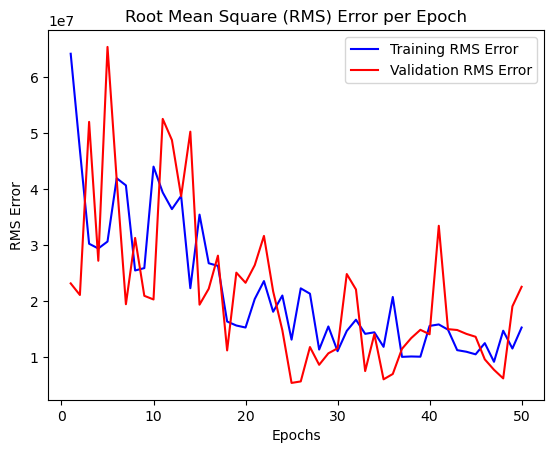

In [ ]:

# Define the model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(8,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=50, validation_data=(X_test, y_test))

# Extract the loss and validation loss from the history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculate the Root Mean Square (RMS) error from the loss
rms_error = np.sqrt(loss)
val_rms_error = np.sqrt(val_loss)


# Plot the RMS error per epoch
epochs = range(1, len(loss) + 1)
plt.plot(epochs, rms_error, 'b', label='Training RMS Error')
plt.plot(epochs, val_rms_error, 'r', label='Validation RMS Error')
plt.title('Root Mean Square (RMS) Error per Epoch')
plt.xlabel('Epochs')
plt.ylabel('RMS Error')
plt.legend()
plt.show()

Epoch 1/150


52/52 [==============================] - 1s 5ms/step - loss: 6320062629675008.0000 - accuracy: 0.7386 - val_loss: 3558292626341888.0000 - val_accuracy: 0.8594
Epoch 2/150
52/52 [==============================] - 0s 3ms/step - loss: 3309727299665920.0000 - accuracy: 0.7776 - val_loss: 3583287456956416.0000 - val_accuracy: 0.8594
Epoch 3/150
52/52 [==============================] - 0s 2ms/step - loss: 3020505812566016.0000 - accuracy: 0.7706 - val_loss: 3619562750738432.0000 - val_accuracy: 0.8594
Epoch 4/150
52/52 [==============================] - 0s 2ms/step - loss: 2930505041313792.0000 - accuracy: 0.7784 - val_loss: 4093755057504256.0000 - val_accuracy: 0.8594
Epoch 5/150
52/52 [==============================] - 0s 2ms/step - loss: 2736718264401920.0000 - accuracy: 0.7823 - val_loss: 3292436566638592.0000 - val_accuracy: 0.8594
Epoch 6/150
52/52 [==============================] - 0s 2ms/step - loss: 2616896193036288.0000 - accuracy: 0.7761 - val_loss: 3944147924811776.0000 - val_acc

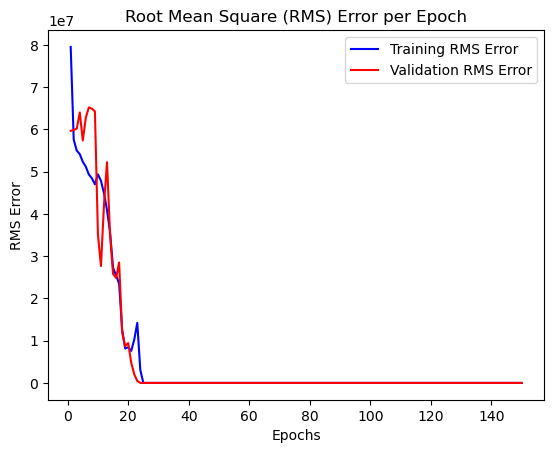

In [ ]:

# # Define the model architecture
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(8,)),
#     Dense(32, activation='relu'),
#     Dense(16, activation='relu'),
#     Dense(8, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

# history = model.fit(X_train, y_train, epochs=150, batch_size=50, validation_data=(X_test, y_test))

# # Extract the loss and validation loss from the history
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Calculate the Root Mean Square (RMS) error from the loss
# rms_error = np.sqrt(loss)
# val_rms_error = np.sqrt(val_loss)


# # Plot the RMS error per epoch
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, rms_error, 'b', label='Training RMS Error')
# plt.plot(epochs, val_rms_error, 'r', label='Validation RMS Error')
# plt.title('Root Mean Square (RMS) Error per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('RMS Error')
# plt.legend()
# plt.show()

In [ ]:
# Assuming X_test is the data you want to make predictions on
predictions = model.predict(X_test)

# Printing the results
print(predictions)

binary_predictions = (predictions > 0.5).astype(int)
print(binary_predictions)


20/20 [==============================] - 0s 2ms/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)


Accuracy: 0.859375
[[550   0]
 [ 90   0]]


/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
